# Bionformatics analysis of public scRNAseq

Raw files were downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134809, in this analysis we used only the following samples:
- GSM3972011 (SampleID: Ptz6)
- GSM3972013 (SampleID: Ptz7)
- GSM3972016 (SampleID: Ptz8)
- GSM3972017 (SampleID: Ptz10)
- GSM3972020 (SampleID: Ptz11)
- GSM3972022 (SampleID: Ptz12)
- GSM3972026 (SampleID: Ptz14)
- GSM3972028 (SampleID: Ptz15)
- GSM3972030 (SampleID: Ptz16)

From the GEO series we excluded the samples with "status" equal to "PBMC" and "Uninvolved" and we keep only the "Involved". 
From the "Involved" samples we discard the Ptz5 because the 10X esperiment was performed with V1 kit and we focus only on V2 kit sample preparation. 

The aim of this notebook is to select high quality T cells and extract the cellID to use in the future analysis when this dataset will be integrated with others. 

After data ingestion (concatenation steps were performed in R and are available here : https://nbviewer.jupyter.org/github/luglilab/SP028_Autoimmunity/blob/main/IBD_dataset_preparsing.ipynb ), quality control and cell diagnosis were performed in order to filter out these with low quality. Next we performed normalization and dimensionality reduction and perform clustering with Leiden algoritm with 3 different resolution. Cell CD3E CD8A CD4 CD45 are colored in the last UMAP plot. 

In this preliminary analyisis we did not perform Integration/Batch effect/Imputation becasue it's not required for the goal but we perform a manually selection of leucocyte. 

### 0 - Import of Python/R package 

In [ ]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [6]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
#sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### 1 - scRNAseq and associate metadata ingestion 

In [12]:
path_ibd="/mnt/lugli/SP028_Autoimmunity/dataset/IBD_RNA_sequencing_result/IBD_counts/10Xmerge/"
adata_ibd = sc.read("".join([path_ibd,"matrix.mtx"]), cache=False)
adata_ibd = adata_ibd.transpose()
adata_ibd.X = adata_ibd.X.toarray()
barcodes = pd.read_csv("".join([path_ibd,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_ibd,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_ibd.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_ibd.var = genes

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [21]:
Metadata_ibd = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/dataset/IBD_RNA_sequencing_result/IBD_counts/IBD_metadata.csv",header=0,low_memory=False)
Metadata_ibd.columns = ['Cell', 'nGene', 'nUMI', 'CellFromTumor', 'PatientNumber', 'TumorSite','TumorType']
Metadata_ibd = Metadata_ibd[['Cell', 'nGene', 'nUMI', 'CellFromTumor', 'PatientNumber', 'TumorType','TumorSite']]

In [22]:
Metadata_ibd.head()

,Cell,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite
0,6_AAACCTGAGAGCTGCA-1,329,2022,False,6,IBD,Ileum
1,6_AAACCTGCATCCGCGA-1,662,3422,False,6,IBD,Ileum
2,6_AAACCTGGTGCCTGTG-1,920,3183,False,6,IBD,Ileum
3,6_AAACCTGGTTCCCGAG-1,423,2909,False,6,IBD,Ileum
4,6_AAACCTGTCACCAGGC-1,988,2796,False,6,IBD,Ileum


In [24]:
adata_ibd.obs['CellId'] = Metadata_ibd["Cell"].to_list()
adata_ibd.obs['CellFromTumor'] = Metadata_ibd["CellFromTumor"].to_list()
adata_ibd.obs['PatientNumber'] = Metadata_ibd["PatientNumber"].to_list()
adata_ibd.obs['TumorType'] = Metadata_ibd["TumorType"].to_list()
adata_ibd.obs['TumorSite'] = Metadata_ibd["TumorSite"].to_list()
adata_ibd.obs['CellType'] = None

### 2 Diagnostic plots, pre-filtering 

In [28]:
adata_ibd = adata_ibd[:,adata_ibd.X.sum(axis=0) > 0]

/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [29]:
nCountsPerGene = np.sum(adata_ibd.X, axis=0)
nCellsPerGene = np.sum(adata_ibd.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 3.0  -  12512358.0
Number of cells in which each gene is detected: 3  -  54185


In [30]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata_ibd, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata_ibd.var_names.str.startswith('MT-')
ribo_genes = adata_ibd.var_names.str.startswith(("RPS","RPL"))
# for each cell compute fraction of counts in mito genes vs. all genes
adata_ibd.obs['percent_mito'] = np.sum(
    adata_ibd[:, mito_genes].X, axis=1) / np.sum(adata_ibd.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata_ibd.obs['n_counts'] = adata_ibd.X.sum(axis=1)
#
adata_ibd.obs['percent_ribo'] = np.sum(
    adata_ibd[:, ribo_genes].X, axis=1) / np.sum(adata_ibd.X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [31]:
adata_ibd.shape

(55365, 21508)

Plot of QC - N_genes

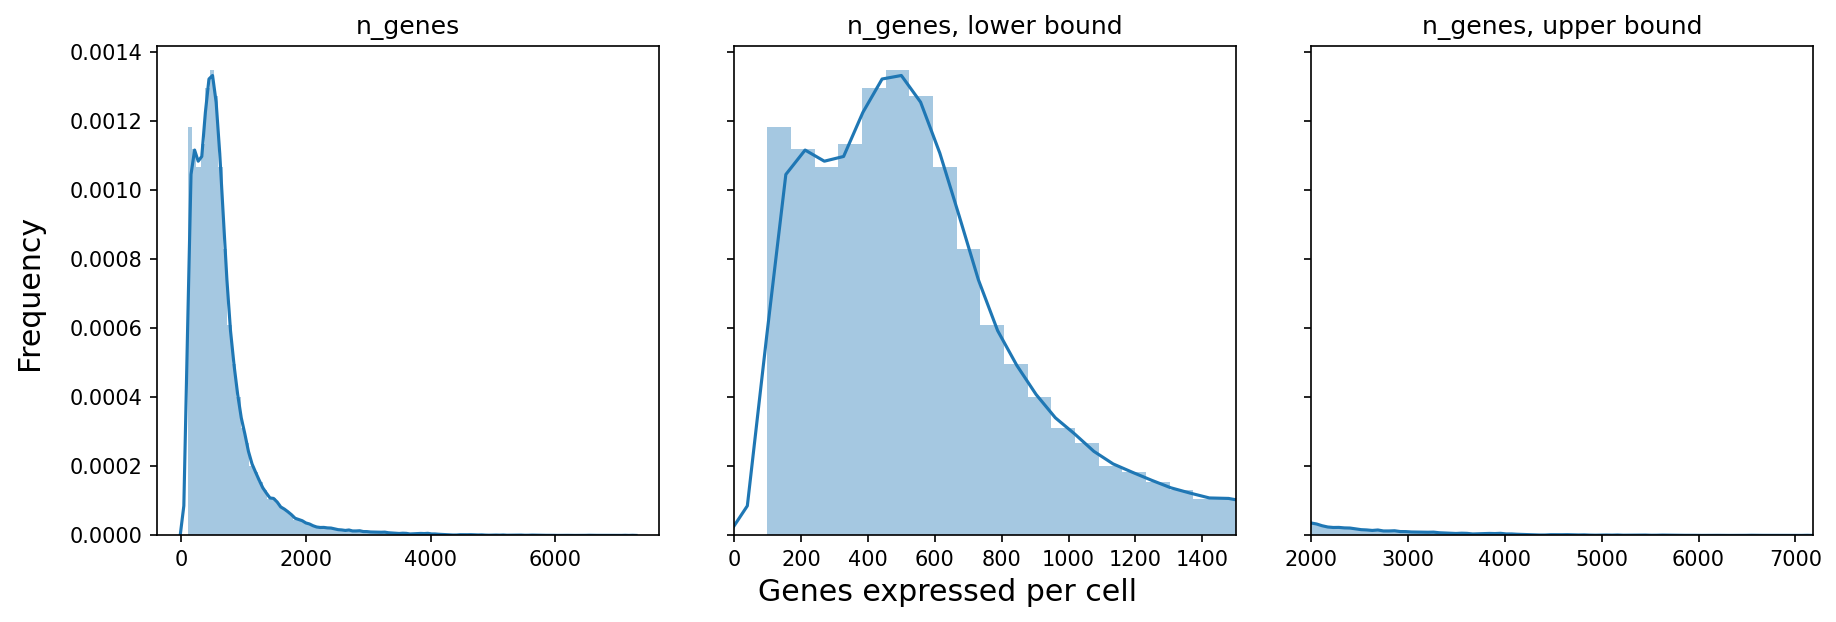

In [33]:
import seaborn as sns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata_ibd.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata_ibd.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Plot of Percent Mito

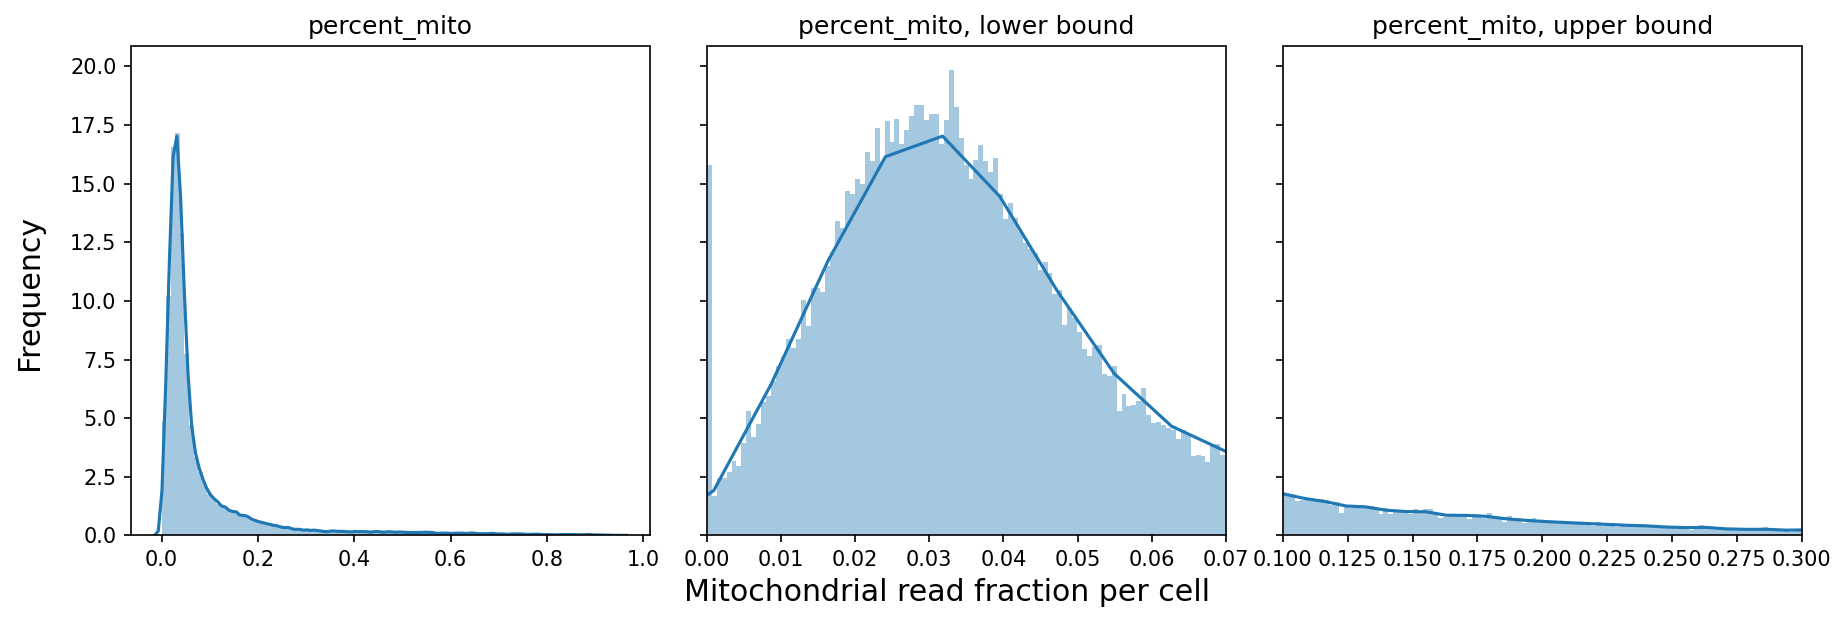

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata_ibd.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

Plot of N_genes N_counts Percent Mito 

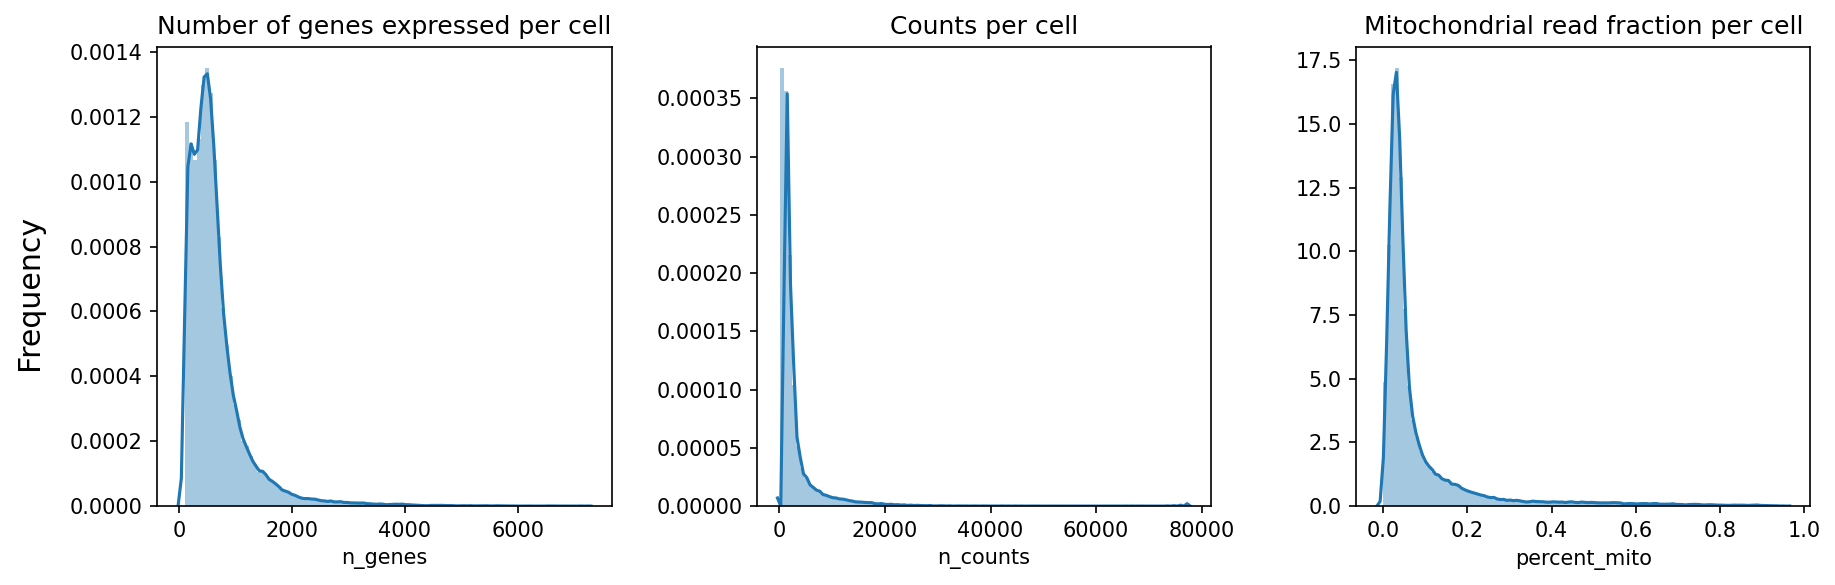

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata_ibd.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata_ibd.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata_ibd.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

# 3 - Filtering low quality cells

In [37]:
# initial cuts
sc.pp.filter_cells(adata_ibd, min_genes=200 )
sc.pp.filter_genes(adata_ibd, min_cells=3 )

filtered out 6449 cells that have less than 200 genes expressed


/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 60 genes that are detected in less than 3 cells


In [38]:
adata_ibd.write("/mnt/lugli/SP028_Autoimmunity/h5_files/IBD_afterQC.h5ad")

/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical


In [39]:
keep = (adata_ibd.obs['n_genes'] > 200) 
print(sum(keep))

48845


In [41]:
adata_ibd = adata_ibd[keep, :]

/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### 4 - Normalization

Normalize each cell by total counts over all genes, so that every cell has
the same total count after normalization.

In [43]:
sc.pp.normalize_per_cell(adata_ibd, counts_per_cell_after=1e4)
sc.pp.log1p(adata_ibd)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:18): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### 5 - Highest expressed genes
Fraction of counts assigned to each gene over all cells.

Computes, for each gene, the fraction of counts assigned to that gene within
a cell. The `n_top` genes with the highest mean fraction over all cells are
plotted as boxplots.

*We expect to see the “usual suspects”, i.e., mitochondrial genes, actin,
    ribosomal protein, MALAT1. A few spike-in transcripts may also be
    present here, though if all of the spike-ins are in the top 50, it
    suggests that too much spike-in RNA was added. A large number of
    pseudo-genes or predicted genes may indicate problems with alignment.*
    -- Davis McCarthy and Aaron Lun

normalizing counts per cell
    finished (0:00:03)


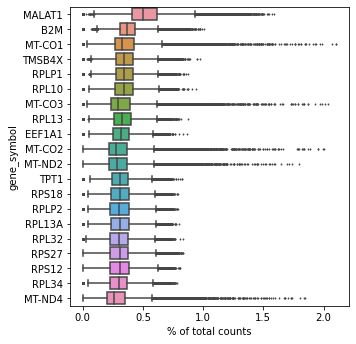

In [49]:
sc.pl.highest_expr_genes(adata_ibd, n_top=20)

# 6 - Dimensionality reduction

In [50]:
sc.pp.scale(adata_ibd,max_value=10)
sc.tl.pca(adata_ibd,svd_solver='arpack')
sc.pp.neighbors(adata_ibd,n_neighbors=15, n_pcs=30)
#sc.tl.louvain(adata, resolution = 0.5)
#sc.tl.tsne(adata, perplexity = 30, random_state = 100)
sc.tl.umap(adata_ibd, random_state = 100)

computing PCA
    with n_comps=50
    finished (0:00:29)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:53)


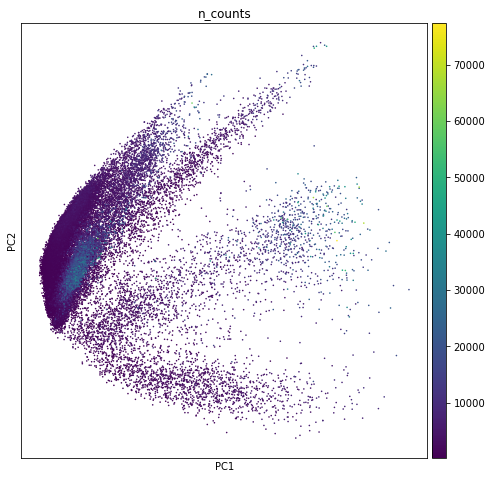

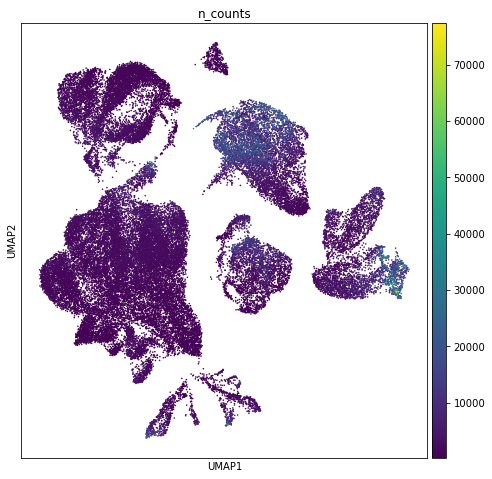

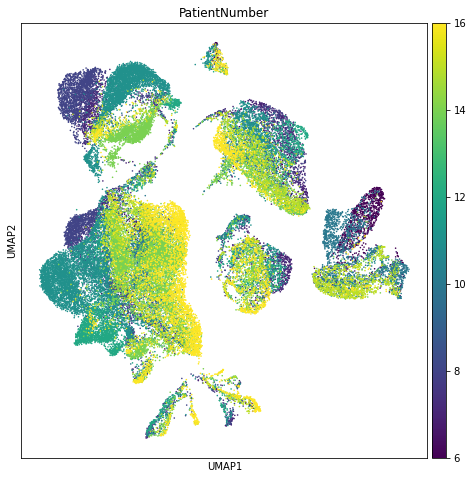

In [53]:
sc.pl.pca_scatter(adata_ibd, color='n_counts',s=10)
sc.pl.umap(adata_ibd, color='n_counts',s=10)
sc.pl.umap(adata_ibd, color='PatientNumber',s=10)

# 7 - Leiden Clustering

In [56]:
sc.tl.louvain(adata_ibd, resolution=0.8, key_added='louvain_r0.8', random_state=10)
sc.tl.louvain(adata_ibd,resolution=0.6, key_added='louvain_r0.6',random_state=10)
sc.tl.louvain(adata_ibd, resolution=0.4, key_added='louvain_r0.4', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain_r0.8', the cluster labels (adata.obs, categorical) (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain_r0.6', the cluster labels (adata.obs, categorical) (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r0.4', the cluster labels (adata.obs, categorical) (0:00:11)


In [61]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

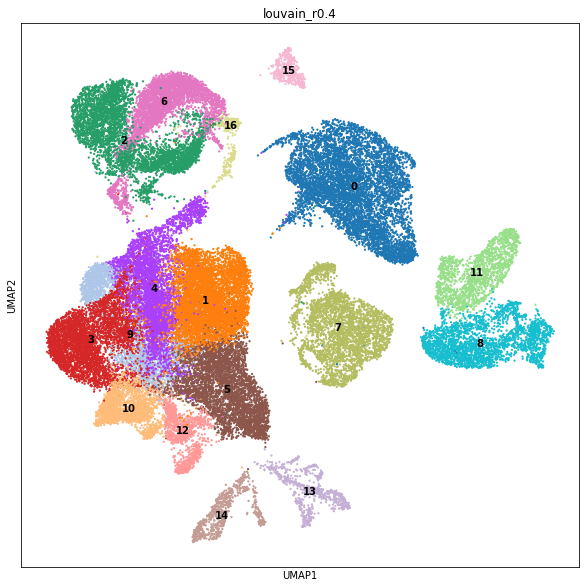

In [69]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata_ibd, color=['louvain_r0.4'],legend_loc='on data',s=20,color_map=mymap)

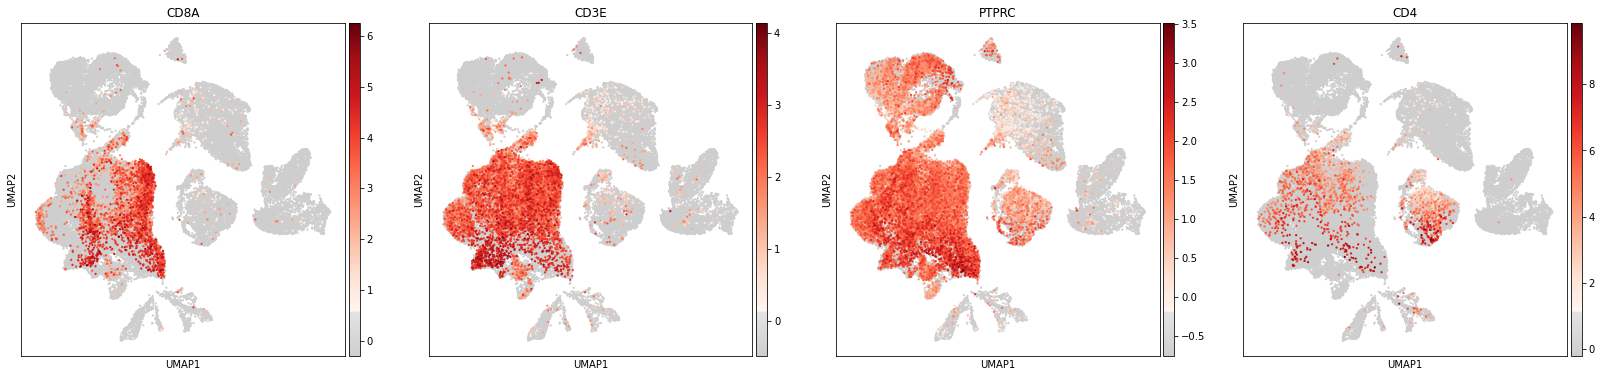

In [67]:
sc.pl.umap(adata_ibd, color=['CD8A','CD3E','PTPRC','CD4'],legend_loc='on data',s=20,color_map=mymap)

# 8 - Marker Genes

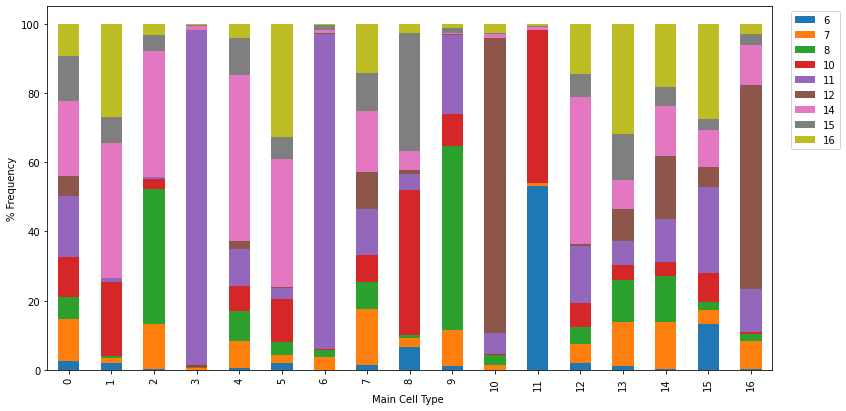

In [72]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_ibd.obs.groupby("louvain_r0.4")["PatientNumber"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Main Cell Type ")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [78]:
malat1 = adata_ibd.var_names.str.startswith(("MALAT1"))
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata_ibd.var_names.str.startswith(("MT-","MTRNR"))
ribo_genes = adata_ibd.var_names.str.startswith(("RPS","RPL"))
remove = np.add(mito_genes,ribo_genes,malat1)
keep = np.invert(remove)

adata_ibd = adata_ibd[:,keep]
sc.tl.rank_genes_groups(adata_ibd, 'louvain_r0.4', method='wilcoxon',key_added='rank_genes_louvain_r0.4',n_genes=100)

ranking genes


/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_louvain_r0.4']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:04:06)


/home/spuccio/miniconda3/envs/scrnseq/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [80]:
pd.DataFrame(adata_ibd.uns['rank_genes_louvain_r0.4']['names']).to_csv("/mnt/lugli/SP028_Autoimmunity/dataset/IBD_RNA_sequencing_result/Results/IDB_leiden_04_markers_genes_wilcoxon.csv",header=True,index=False)

In [96]:
from IPython.display import IFrame 
gsheetUrl="https://docs.google.com/spreadsheets/d/1ZR0sz25orRFBoHh3DmOEDDtx-JhEUjLZz_vkUaBatfs/edit#gid=1157425441"
display(IFrame(gsheetUrl, width=1000, height=400))

T_cell following the plot above are distribuited in the following clustering:
C1, C3, C4, C5, C9, C10, C12, C7